# Problem statement

Most of the time when we need rainfall data from rainfall stations, not all areas we want to study have rainfall stations, so satellite data is a practical solution to replace the absence of this data. However, of course the estimated data (satellite) will certainly have an error when compared to real measurement data (observation), therefore it takes correction first to use satellite data before being applied to other uses.
Based on Kartika's research, the best method to correct biased rainfall data from observations is to use the quantile mapping method, therefore corrections will be made using the quantile mapping method.

# Objective

- Correcting rainfall data per rainfall classification using quantile mapping
- Calculating rmse and correlation of all correction factors per station
- Determine the best station to be the corrector station per rainfall classification

# Import Librabries

In [2]:
import pandas as pd
from scipy import signal
from scipy import stats
from sklearn.metrics import mean_squared_error
import numpy as np
import pvlib
from scipy import interpolate
from functools import reduce
import glob
import datetime as dt
import netCDF4 as nc4

# Data Loading

In [4]:
# read rainfall satellite data and save it in tmp variable
tmp=pd.read_excel('D:/Happy/satellite_correction/data_satellite/Hasil_CHIRPSStasiunJeneberang.xlsx')

start_date = '2014-01-01'
end_date = '2018-12-31'

# Select DataFrame rows between two dates
mask = (tmp['date'] > start_date) & (tmp['date'] <= end_date)
tmp = tmp.loc[mask].drop(['PCH STASIUN MACINI SOMBALA'], axis=1).reset_index(drop=True)
tmp.head()

,date,PCH STASIUN LIMBUNGA,PCH STASIUN MANGEMPANG,PCH STASIUN LENGKESE,PCH STASIUN KAMPILI,PCH STASIUN KD1,PCH STASIUN MALINO,PCH STASIUN PANAIKANG,PCH STASIUN POS1,PCH STASIUN BILI-BILI
0,2014-01-02,9.390553,14.190951,0.000000,12.058479,0.000000,0.000000,0.000000,0.000000,11.155343
1,2014-01-03,9.390553,0.000000,10.028090,12.058479,0.000000,9.724977,9.724977,8.186147,11.155343
2,2014-01-04,18.781105,0.000000,20.056181,24.116959,14.426726,19.449955,19.449955,24.558439,22.310686
3,2014-01-05,18.781105,28.381903,20.056181,24.116959,28.853453,19.449955,19.449955,16.372293,22.310686
4,2014-01-06,14.561491,11.964704,10.550665,19.995438,11.641550,10.292566,10.292566,9.130646,25.466198


In [5]:
# read rainfall observation data and save it in obs variable
obs=pd.read_excel('D:/Happy/satellite_correction/uji_data_hujan_obs/rainfall_QC.xlsx').drop(['Unnamed: 0'], axis=1)
obs.rename(columns = {'TANGGAL':'date'}, inplace = True)

# save the name of each station
sta_name=obs.columns[1:].values
sta_name

array(['PCH STASIUN BILI-BILI', 'PCH STASIUN KAMPILI', 'PCH STASIUN KD1',
       'PCH STASIUN LENGKESE', 'PCH STASIUN LIMBUNGA',
       'PCH STASIUN MALINO', 'PCH STASIUN MANGEMPANG',
       'PCH STASIUN PANAIKANG', 'PCH STASIUN POS1'], dtype=object)

In [6]:
# check the observation data
obs.head()

,date,PCH STASIUN BILI-BILI,PCH STASIUN KAMPILI,PCH STASIUN KD1,PCH STASIUN LENGKESE,PCH STASIUN LIMBUNGA,PCH STASIUN MALINO,PCH STASIUN MANGEMPANG,PCH STASIUN PANAIKANG,PCH STASIUN POS1
0,2014-01-02,7,1.0,13,4,11,3,0.011297,0,7
1,2014-01-03,0,2.0,17,53,1,21,0.111354,29,69
2,2014-01-04,22,5.0,15,46,16,29,0.069395,29,43
3,2014-01-05,0,0.0,9,28,14,16,0.032277,12,20
4,2014-01-06,22,1.0,9,77,14,46,9.000000,62,53


In [7]:
# check the information of observational data
obs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    1825 non-null   datetime64[ns]
 1   PCH STASIUN BILI-BILI   1825 non-null   int64         
 2   PCH STASIUN KAMPILI     1825 non-null   float64       
 3   PCH STASIUN KD1         1825 non-null   int64         
 4   PCH STASIUN LENGKESE    1825 non-null   int64         
 5   PCH STASIUN LIMBUNGA    1825 non-null   int64         
 6   PCH STASIUN MALINO      1825 non-null   int64         
 7   PCH STASIUN MANGEMPANG  1825 non-null   float64       
 8   PCH STASIUN PANAIKANG   1825 non-null   int64         
 9   PCH STASIUN POS1        1825 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(7)
memory usage: 142.7 KB


We have 8 stations columns with numerical datatype. These data will be used for correcting the satellite data.

In [8]:
# check the information of satellite data
tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    1825 non-null   datetime64[ns]
 1   PCH STASIUN LIMBUNGA    1825 non-null   float64       
 2   PCH STASIUN MANGEMPANG  1825 non-null   float64       
 3   PCH STASIUN LENGKESE    1825 non-null   float64       
 4   PCH STASIUN KAMPILI     1825 non-null   float64       
 5   PCH STASIUN KD1         1825 non-null   float64       
 6   PCH STASIUN MALINO      1825 non-null   float64       
 7   PCH STASIUN PANAIKANG   1825 non-null   float64       
 8   PCH STASIUN POS1        1825 non-null   float64       
 9   PCH STASIUN BILI-BILI   1825 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 142.7 KB


In [9]:
# select grid that contain from observational
sat=tmp.copy()

In [10]:
# check the satellite data
sat.head()

,date,PCH STASIUN LIMBUNGA,PCH STASIUN MANGEMPANG,PCH STASIUN LENGKESE,PCH STASIUN KAMPILI,PCH STASIUN KD1,PCH STASIUN MALINO,PCH STASIUN PANAIKANG,PCH STASIUN POS1,PCH STASIUN BILI-BILI
0,2014-01-02,9.390553,14.190951,0.000000,12.058479,0.000000,0.000000,0.000000,0.000000,11.155343
1,2014-01-03,9.390553,0.000000,10.028090,12.058479,0.000000,9.724977,9.724977,8.186147,11.155343
2,2014-01-04,18.781105,0.000000,20.056181,24.116959,14.426726,19.449955,19.449955,24.558439,22.310686
3,2014-01-05,18.781105,28.381903,20.056181,24.116959,28.853453,19.449955,19.449955,16.372293,22.310686
4,2014-01-06,14.561491,11.964704,10.550665,19.995438,11.641550,10.292566,10.292566,9.130646,25.466198


In [11]:
# check the information of satellite data
sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    1825 non-null   datetime64[ns]
 1   PCH STASIUN LIMBUNGA    1825 non-null   float64       
 2   PCH STASIUN MANGEMPANG  1825 non-null   float64       
 3   PCH STASIUN LENGKESE    1825 non-null   float64       
 4   PCH STASIUN KAMPILI     1825 non-null   float64       
 5   PCH STASIUN KD1         1825 non-null   float64       
 6   PCH STASIUN MALINO      1825 non-null   float64       
 7   PCH STASIUN PANAIKANG   1825 non-null   float64       
 8   PCH STASIUN POS1        1825 non-null   float64       
 9   PCH STASIUN BILI-BILI   1825 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 142.7 KB


We have the clean rainfall station data with numerical datatype as well, now we are ready to correct the data.

# Exploratory Data Analysis

<Axes: xlabel='date'>

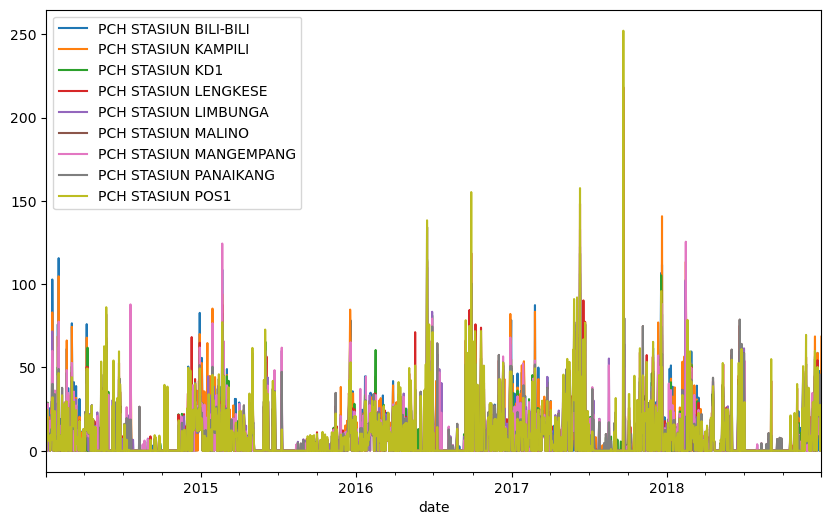

In [12]:
sat.plot(x="date", y=sta_name,
        kind="line", figsize=(10, 6))

<Axes: xlabel='date'>

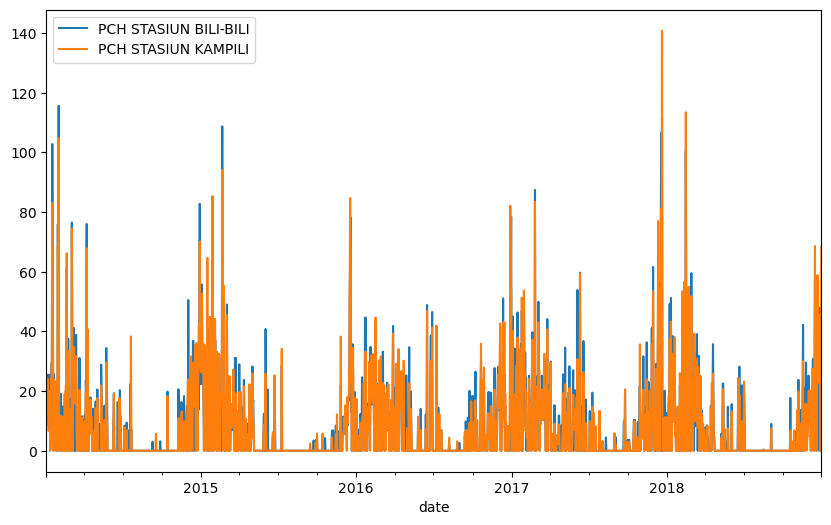

In [13]:
sat.plot(x="date", y=sta_name[:2],
        kind="line", figsize=(10, 6))

<Axes: xlabel='date'>

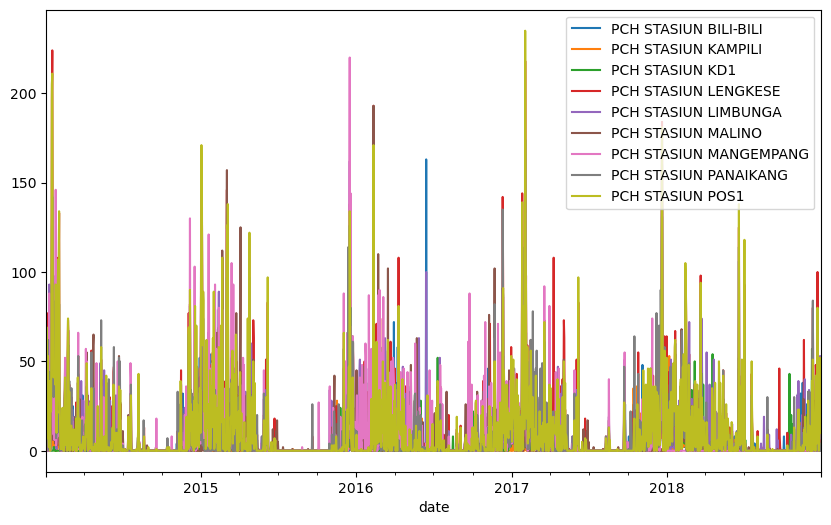

In [14]:
obs.plot(x="date", y=sta_name,
        kind="line", figsize=(10, 6))

In [15]:
obs[obs[sta_name[3]]>200][['date',sta_name[3]]]

,date,PCH STASIUN LENGKESE
14,2014-01-16,224
1127,2017-02-02,218


In [16]:
for i in sta_name:
    if not (obs[obs[i]>200]).empty:
        print ('===============================================================================')
        print (obs[obs[i]>200])
        print ('===============================================================================')
        print ('\n\n\n')

           date  PCH STASIUN BILI-BILI  PCH STASIUN KAMPILI  PCH STASIUN KD1  \
14   2014-01-16                     53                 11.0                0   
1127 2017-02-02                     36                 21.0               36   

      PCH STASIUN LENGKESE  PCH STASIUN LIMBUNGA  PCH STASIUN MALINO  \
14                     224                   143                  31   
1127                   218                    69                  34   

      PCH STASIUN MANGEMPANG  PCH STASIUN PANAIKANG  PCH STASIUN POS1  
14                     146.0                    142               211  
1127                   133.0                    174               235  




          date  PCH STASIUN BILI-BILI  PCH STASIUN KAMPILI  PCH STASIUN KD1  \
714 2015-12-17                     12                 52.0               24   

     PCH STASIUN LENGKESE  PCH STASIUN LIMBUNGA  PCH STASIUN MALINO  \
714                   138                   162                 101   

     PCH STASIUN MAN

# Quantile Mapping

In [17]:
# define the function
def ecdf(x): # empirical CDF computation
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

def QuantileMappinBR(y_obs,y_mod): # Bias Removal using empirical quantile mapping
    y_cor = y_mod
    x_obs,cdf_obs = ecdf(y_obs)
    x_mod,cdf_mod = ecdf(y_mod)
    # Translate data to the quantile domain, apply the CDF operator
    cdf = interpolate.interp1d(x_mod,cdf_mod,kind='nearest',fill_value='extrapolate')
    qtile = cdf(y_mod)
    # Apply de CDF^-1 operator to reverse the operation to radiation domain
    cdfinv = interpolate.interp1d(cdf_obs,x_obs,kind='nearest',fill_value='extrapolate')
    y_cor = cdfinv(qtile)
    return y_cor

## CH Ringan

### Dibalik scriptnya, satellite dulu baru obs

In [28]:
tabel_performa=pd.DataFrame(columns=['stasiun','rmse','rmse corr','rmse wo otl','rmse wo otl corr',\
                                     'korelasi','korelasi corr','korelasi wo otl','korelasi wo otl corr'])
path='D:/Happy/satellite_correction/klasifikasi_hujan/classified_CHIRPS/acuan_koreksi/'
value='Ringan'
sta=pd.ExcelFile(path+'Hasil_CHIRPSStasiunJeneberang_classified_'+value+'.xlsx')

for i in range (len(sta_name)):
    globals()['st'+str(i)]=pd.read_excel(path+'Hasil_CHIRPSStasiunJeneberang_classified_'+value+'.xlsx',\
              sheet_name=sta_name[i])
    globals()['st'+str(i)]=globals()['st'+str(i)].dropna()
    obs_st=globals()['st'+str(i)].iloc[:,3]
    satellite_st=globals()['st'+str(i)].iloc[:,1]

    r1,p1=stats.pearsonr(obs_st, satellite_st)
    rmse1=mean_squared_error(obs_st, satellite_st)

    #quantileMapping Bias Correction
    satellite_corr=QuantileMappinBR(satellite_st,obs_st)
    r2,p2=stats.pearsonr(obs_st, satellite_corr)
    rmse2=mean_squared_error(obs_st, satellite_corr)
    globals()['st'+str(i)]['satellite corr']=satellite_corr

    #without outlier
    sss=globals()['st'+str(i)]
    globals()['st'+str(i)+'wo_otl']=sss[(sss.iloc[:,3]<250) & (sss.iloc[:,1]<250)]

    obs_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,3]
    satellite_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,1]
    r3,p3=stats.pearsonr(obs_st_wo_otl, satellite_st_wo_otl)
    rmse3=mean_squared_error(obs_st_wo_otl, satellite_st_wo_otl)

    #quantileMapping Bias Correction without outlier
    satellite_corr_wo_otl=QuantileMappinBR(satellite_st_wo_otl, obs_st_wo_otl)
    r4,p4=stats.pearsonr(obs_st_wo_otl, satellite_corr_wo_otl)
    rmse4=mean_squared_error(obs_st_wo_otl, satellite_corr_wo_otl)
    globals()['st'+str(i)+'wo_otl']['satellite corr wo otl']=satellite_corr_wo_otl


    tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
                    'rmse':rmse1,'rmse corr':rmse2,'rmse wo otl':rmse3,'rmse wo otl corr':rmse4,\
                    'korelasi':r1,'korelasi corr':r2,\
                    'korelasi wo otl':r3,'korelasi wo otl corr':r4}]))

tabel_performa=tabel_performa.reset_index()
tabel_performa=tabel_performa.iloc[:,1:]
tabel_performa.sort_values(by=['korelasi corr','rmse corr'], inplace=True,
               ascending = [False, True])

# get index of best corrector
ringan1=tabel_performa.stasiun[0]


tabel_performa

C:\Users\MSIX\AppData\Local\Temp\ipykernel_9748\3493333335.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
C:\Users\MSIX\AppData\Local\Temp\ipykernel_9748\3493333335.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
C:\Users\MSIX\AppData\Local\Temp\ipykernel_9748\3493333335.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
C:\Users\MSIX\AppData\Local\Temp\ipykernel_9748\3493333335.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. 

,stasiun,rmse,rmse corr,rmse wo otl,rmse wo otl corr,korelasi,korelasi corr,korelasi wo otl,korelasi wo otl corr
4,PCH STASIUN LIMBUNGA,151.900645,66.296050,151.900645,66.296050,0.259553,0.882135,0.259553,0.882135
5,PCH STASIUN MALINO,150.074001,60.824209,150.074001,60.824209,0.210465,0.864467,0.210465,0.864467
3,PCH STASIUN LENGKESE,322.687781,209.604622,322.687781,209.604622,0.290729,0.856444,0.290729,0.856444
8,PCH STASIUN POS1,360.425167,240.080401,360.425167,240.080401,0.267955,0.847464,0.267955,0.847464
6,PCH STASIUN MANGEMPANG,228.513787,140.773165,228.513787,140.773165,0.352092,0.845028,0.352092,0.845028
7,PCH STASIUN PANAIKANG,199.337254,104.214839,199.337254,104.214839,0.251764,0.841938,0.251764,0.841938
2,PCH STASIUN KD1,77.297299,21.297216,77.297299,21.297216,0.258632,0.838669,0.258632,0.838669
1,PCH STASIUN KAMPILI,48.183846,13.657136,48.183846,13.657136,0.187888,0.760998,0.187888,0.760998
0,PCH STASIUN BILI-BILI,79.068993,31.448177,79.068993,31.448177,0.216357,0.709958,0.216357,0.709958


<Axes: xlabel='date'>

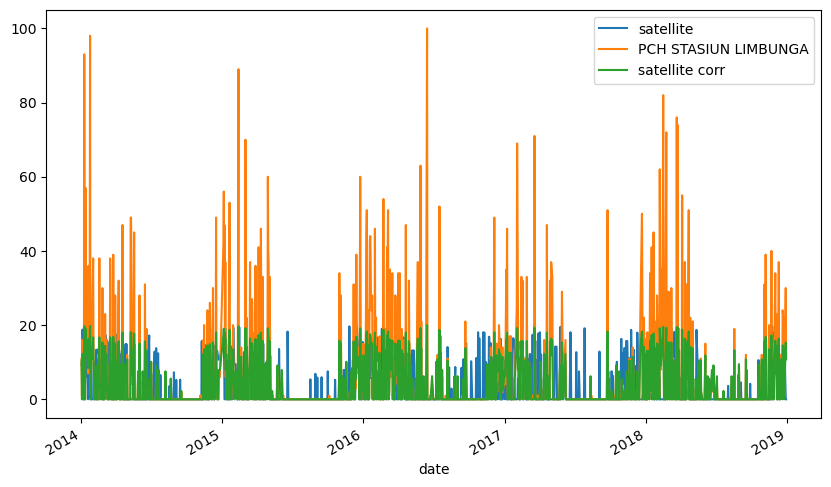

In [29]:
st4.plot(x="date", y=['satellite',sta_name[4],'satellite corr'],
        kind="line", figsize=(10, 6))

<Axes: xlabel='date'>

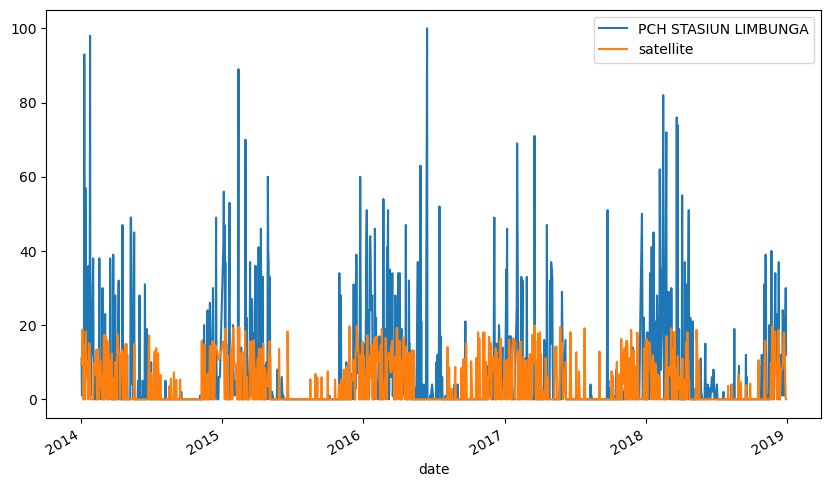

In [30]:
# sebelum dikoreksi
st4.plot(x="date",  y=['PCH STASIUN LIMBUNGA','satellite'],
        kind="line", figsize=(10, 6))

<Axes: xlabel='date'>

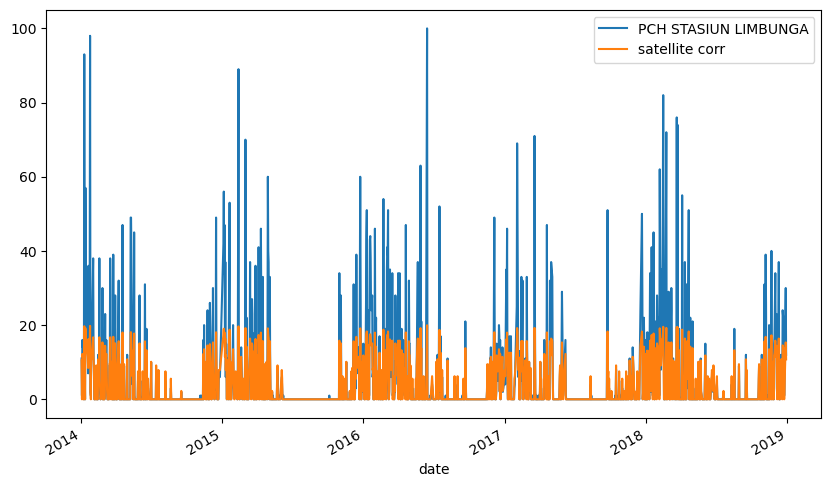

In [31]:
# setelah dikoreksi
st4.plot(x="date", y=['PCH STASIUN LIMBUNGA','satellite corr'],
        kind="line", figsize=(10, 6))

### Script Quantile_Mapping(obs,satellite)

In [32]:
tabel_performa=pd.DataFrame(columns=['stasiun','rmse','rmse corr','rmse wo otl','rmse wo otl corr',\
                                     'korelasi','korelasi corr','korelasi wo otl','korelasi wo otl corr'])
path='D:/Happy/satellite_correction/klasifikasi_hujan/classified_CHIRPS/acuan_koreksi/'
value='Ringan'
sta=pd.ExcelFile(path+'Hasil_CHIRPSStasiunJeneberang_classified_'+value+'.xlsx')

for i in range (len(sta_name)):
    globals()['st'+str(i)]=pd.read_excel(path+'Hasil_CHIRPSStasiunJeneberang_classified_'+value+'.xlsx',\
              sheet_name=sta_name[i])
    globals()['st'+str(i)]=globals()['st'+str(i)].dropna()
    obs_st=globals()['st'+str(i)].iloc[:,3]
    satellite_st=globals()['st'+str(i)].iloc[:,1]

    r1,p1=stats.pearsonr(satellite_st, obs_st)
    rmse1=mean_squared_error(satellite_st, obs_st)

    #quantileMapping Bias Correction
    satellite_corr=QuantileMappinBR(obs_st,satellite_st)
    r2,p2=stats.pearsonr(satellite_corr, obs_st)
    rmse2=mean_squared_error(satellite_corr, obs_st)
    globals()['st'+str(i)]['satellite corr']=satellite_corr

    #without outlier
    sss=globals()['st'+str(i)]
    globals()['st'+str(i)+'wo_otl']=sss[(sss.iloc[:,3]<250) & (sss.iloc[:,1]<250)]

    obs_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,3]
    satellite_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,1]
    r3,p3=stats.pearsonr(satellite_st_wo_otl, obs_st_wo_otl)
    rmse3=mean_squared_error(satellite_st_wo_otl, obs_st_wo_otl)

    #quantileMapping Bias Correction without outlier
    satellite_corr_wo_otl=QuantileMappinBR(obs_st_wo_otl,satellite_st_wo_otl)
    r4,p4=stats.pearsonr(obs_st_wo_otl,satellite_corr_wo_otl)
    rmse4=mean_squared_error(satellite_corr_wo_otl, obs_st_wo_otl)
    globals()['st'+str(i)+'wo_otl']['satellite corr wo otl']=satellite_corr_wo_otl


    tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
                    'rmse':rmse1,'rmse corr':rmse2,'rmse wo otl':rmse3,'rmse wo otl corr':rmse4,\
                    'korelasi':r1,'korelasi corr':r2,\
                    'korelasi wo otl':r3,'korelasi wo otl corr':r4}]))

tabel_performa=tabel_performa.reset_index()
tabel_performa=tabel_performa.iloc[:,1:]
tabel_performa.sort_values(by=['korelasi corr','rmse corr'], inplace=True,
               ascending = [False, True])
# get index of best corrector
ringan2=tabel_performa.stasiun[0]

tabel_performa

C:\Users\MSIX\AppData\Local\Temp\ipykernel_9748\3900419352.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
C:\Users\MSIX\AppData\Local\Temp\ipykernel_9748\3900419352.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
C:\Users\MSIX\AppData\Local\Temp\ipykernel_9748\3900419352.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
C:\Users\MSIX\AppData\Local\Temp\ipykernel_9748\3900419352.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. 

,stasiun,rmse,rmse corr,rmse wo otl,rmse wo otl corr,korelasi,korelasi corr,korelasi wo otl,korelasi wo otl corr
6,PCH STASIUN MANGEMPANG,228.513787,335.185552,228.513787,335.185552,0.352092,0.320961,0.352092,0.320961
8,PCH STASIUN POS1,360.425167,541.880906,360.425167,541.880906,0.267955,0.243686,0.267955,0.243686
3,PCH STASIUN LENGKESE,322.687781,496.561404,322.687781,496.561404,0.290729,0.220240,0.290729,0.220240
2,PCH STASIUN KD1,77.297299,105.127753,77.297299,105.127753,0.258632,0.214559,0.258632,0.214559
4,PCH STASIUN LIMBUNGA,151.900645,238.374527,151.900645,238.374527,0.259553,0.214436,0.259553,0.214436
1,PCH STASIUN KAMPILI,48.183846,30.814511,48.183846,30.814511,0.187888,0.171939,0.187888,0.171939
7,PCH STASIUN PANAIKANG,199.337254,331.871713,199.337254,331.871713,0.251764,0.171444,0.251764,0.171444
0,PCH STASIUN BILI-BILI,79.068993,104.171027,79.068993,104.171027,0.216357,0.166592,0.216357,0.166592
5,PCH STASIUN MALINO,150.074001,244.499679,150.074001,244.499679,0.210465,0.142522,0.210465,0.142522


__Kesimpulan__ :
- pakai `ringan1`, script `satellite` dulu baru `obs`
- pakai stasiun `PCH STASIUN LIMBUNGA`, indeks di sta_name `ke-0`

## CH Sedang

### Script dibalik, satellite dulu baru obs

In [37]:
tabel_performa=pd.DataFrame(columns=['stasiun','rmse','rmse corr','rmse wo otl','rmse wo otl corr',\
                                     'korelasi','korelasi corr','korelasi wo otl','korelasi wo otl corr'])
path='D:/Happy/satellite_correction/klasifikasi_hujan/classified_CHIRPS/acuan_koreksi/'
value='Sedang'
sta=pd.ExcelFile(path+'Hasil_CHIRPSStasiunJeneberang_classified_'+value+'.xlsx')

for i in range (len(sta_name)):
    globals()['st'+str(i)]=pd.read_excel(path+'Hasil_CHIRPSStasiunJeneberang_classified_'+value+'.xlsx',\
              sheet_name=sta_name[i])
    globals()['st'+str(i)]=globals()['st'+str(i)].dropna()
    obs_st=globals()['st'+str(i)].iloc[:,3]
    satellite_st=globals()['st'+str(i)].iloc[:,1]
    r1,p1=stats.pearsonr(obs_st, satellite_st)
    rmse1=mean_squared_error(obs_st, satellite_st)
    
    #quantileMapping Bias Correction
    satellite_corr=QuantileMappinBR(satellite_st,obs_st)
    r2,p2=stats.pearsonr(obs_st, satellite_corr)
    rmse2=mean_squared_error(obs_st, satellite_corr)
    globals()['st'+str(i)]['satellite corr']=satellite_corr
    
    #without outlier
    sss=globals()['st'+str(i)]
    globals()['st'+str(i)+'wo_otl']=sss[(sss.iloc[:,3]<250) & (sss.iloc[:,1]<250)]
    
    obs_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,3]
    satellite_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,1]
    r3,p3=stats.pearsonr(obs_st_wo_otl, satellite_st_wo_otl)
    rmse3=mean_squared_error(obs_st_wo_otl, satellite_st_wo_otl)
    
    #quantileMapping Bias Correction without outlier
    satellite_corr_wo_otl=QuantileMappinBR(satellite_st_wo_otl, obs_st_wo_otl)
    r4,p4=stats.pearsonr(obs_st_wo_otl, satellite_corr_wo_otl)
    rmse4=mean_squared_error(obs_st_wo_otl, satellite_corr_wo_otl)
    
    
    tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
                    'rmse':rmse1,'rmse corr':rmse2,'rmse wo otl':rmse3,'rmse wo otl corr':rmse4,\
                    'korelasi':r1,'korelasi corr':r2,\
                    'korelasi wo otl':r3,'korelasi wo otl corr':r4}]))
tabel_performa=tabel_performa.reset_index()
tabel_performa=tabel_performa.iloc[:,1:]
tabel_performa.sort_values(by=['korelasi corr','rmse corr'], inplace=True,
               ascending = [False, True])
# get index of best corrector
sedang1=tabel_performa.stasiun[0]

tabel_performa

C:\Users\MSIX\AppData\Local\Temp\ipykernel_9748\9590245.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
C:\Users\MSIX\AppData\Local\Temp\ipykernel_9748\9590245.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
C:\Users\MSIX\AppData\Local\Temp\ipykernel_9748\9590245.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
C:\Users\MSIX\AppData\Local\Temp\ipykernel_9748\9590245.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.c

,stasiun,rmse,rmse corr,rmse wo otl,rmse wo otl corr,korelasi,korelasi corr,korelasi wo otl,korelasi wo otl corr
4,PCH STASIUN LIMBUNGA,839.216242,456.774995,839.216242,456.774995,-0.041994,0.932873,-0.041994,0.932873
2,PCH STASIUN KD1,679.918961,447.993540,679.918961,447.993540,0.043345,0.932731,0.043345,0.932731
7,PCH STASIUN PANAIKANG,848.319883,476.711325,848.319883,476.711325,0.136153,0.921772,0.136153,0.921772
0,PCH STASIUN BILI-BILI,644.287559,419.026384,644.287559,419.026384,0.183465,0.912334,0.183465,0.912334
6,PCH STASIUN MANGEMPANG,1139.945854,660.838110,1139.945854,660.838110,-0.004116,0.905366,-0.004116,0.905366
3,PCH STASIUN LENGKESE,1221.509030,762.246459,1221.509030,762.246459,0.029606,0.894825,0.029606,0.894825
1,PCH STASIUN KAMPILI,751.156090,576.312339,751.156090,576.312339,0.022387,0.894739,0.022387,0.894739
8,PCH STASIUN POS1,1150.806363,706.326445,1150.806363,706.326445,0.088723,0.855739,0.088723,0.855739
5,PCH STASIUN MALINO,951.076259,547.683049,951.076259,547.683049,0.014002,0.829026,0.014002,0.829026


<Axes: xlabel='date'>

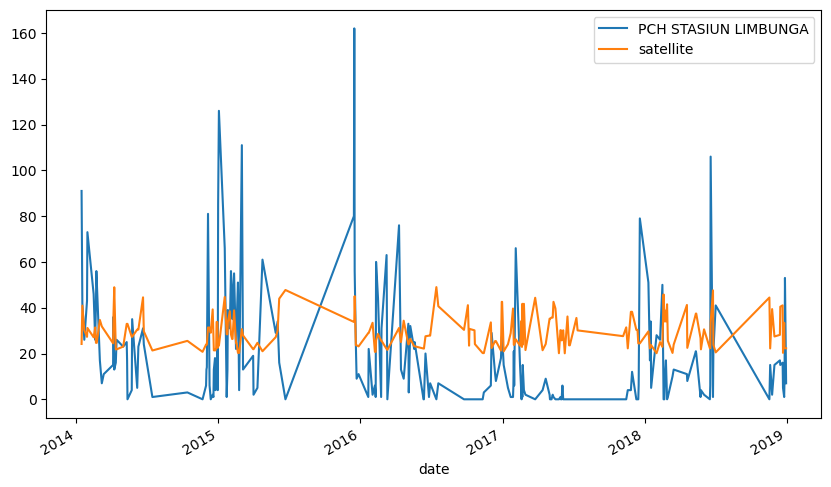

In [38]:
# sebelum dikoreksi
st4.plot(x="date",  y=['PCH STASIUN LIMBUNGA','satellite'],
        kind="line", figsize=(10, 6))

In [39]:
st4

,date,satellite,Klasifikasi,PCH STASIUN LIMBUNGA,satellite corr
0,2014-01-15,24.172510,Sedang,91,45.059818
1,2014-01-17,40.919804,Sedang,42,38.215652
2,2014-01-22,30.156691,Sedang,26,33.457481
3,2014-01-29,27.270535,Sedang,43,38.489899
4,2014-01-30,31.166327,Sedang,73,42.567566
...,...,...,...,...,...
203,2018-12-23,20.283279,Sedang,5,24.663931
204,2018-12-26,33.425198,Sedang,1,22.515423
205,2018-12-27,22.283466,Sedang,10,27.432556
206,2018-12-28,22.283466,Sedang,53,40.651230


<Axes: xlabel='date'>

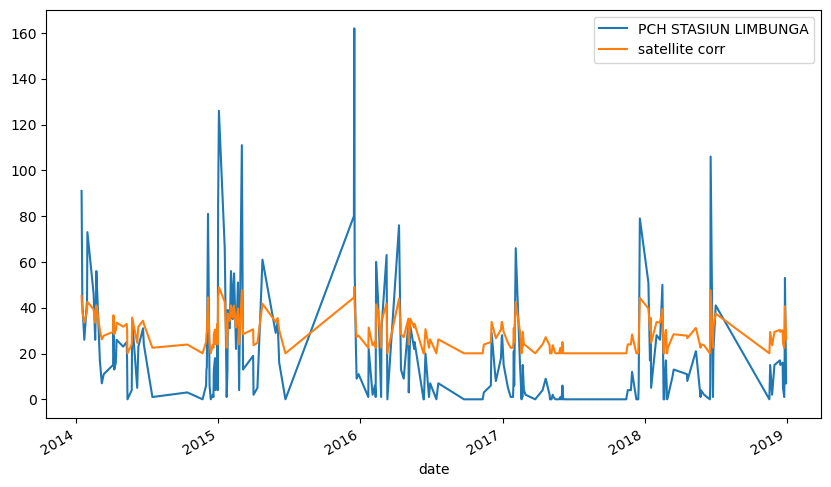

In [40]:
# setelah dikoreksi
st4.plot(x="date", y=['PCH STASIUN LIMBUNGA','satellite corr'],
        kind="line", figsize=(10, 6))

### Script Quantile_Mapping(obs,satellite)

In [22]:
tabel_performa=pd.DataFrame(columns=['stasiun','rmse','rmse corr','rmse wo otl','rmse wo otl corr',\
                                     'korelasi','korelasi corr','korelasi wo otl','korelasi wo otl corr'])
path='D:/Happy/satellite_correction/klasifikasi_hujan/classified_CHIRPS/acuan_koreksi/'
value='Sedang'
sta=pd.ExcelFile(path+'Hasil_CHIRPSStasiunJeneberang_classified_'+value+'.xlsx')

for i in range (len(sta_name)):
    globals()['st'+str(i)]=pd.read_excel(path+'Hasil_CHIRPSStasiunJeneberang_classified_'+value+'.xlsx',\
              sheet_name=sta_name[i])
    globals()['st'+str(i)]=globals()['st'+str(i)].dropna()
    obs_st=globals()['st'+str(i)].iloc[:,3]
    satellite_st=globals()['st'+str(i)].iloc[:,1]
    r1,p1=stats.pearsonr(obs_st, satellite_st)
    rmse1=mean_squared_error(obs_st, satellite_st)
    
    #quantileMapping Bias Correction
    satellite_corr=QuantileMappinBR(obs_st,satellite_st)
    r2,p2=stats.pearsonr(obs_st, satellite_corr)
    rmse2=mean_squared_error(obs_st, satellite_corr)
    
    #without outlier
    sss=globals()['st'+str(i)]
    globals()['st'+str(i)+'wo_otl']=sss[(sss.iloc[:,3]<250) & (sss.iloc[:,1]<250)]
    
    obs_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,3]
    satellite_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,1]
    r3,p3=stats.pearsonr(obs_st_wo_otl, satellite_st_wo_otl)
    rmse3=mean_squared_error(obs_st_wo_otl, satellite_st_wo_otl)
    
    #quantileMapping Bias Correction without outlier
    satellite_corr_wo_otl=QuantileMappinBR(obs_st_wo_otl,satellite_st_wo_otl)
    r4,p4=stats.pearsonr(obs_st_wo_otl, satellite_corr_wo_otl)
    rmse4=mean_squared_error(obs_st_wo_otl, satellite_corr_wo_otl)
    
    
    tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
                    'rmse':rmse1,'rmse corr':rmse2,'rmse wo otl':rmse3,'rmse wo otl corr':rmse4,\
                    'korelasi':r1,'korelasi corr':r2,\
                    'korelasi wo otl':r3,'korelasi wo otl corr':r4}]))
tabel_performa=tabel_performa.reset_index()
tabel_performa=tabel_performa.iloc[:,1:]
tabel_performa.sort_values(by=['korelasi corr','rmse corr'], inplace=True,
               ascending = [False, True])
# get index of best corrector
sedang2=tabel_performa.stasiun[0]

tabel_performa

C:\Users\MSIX\AppData\Local\Temp\ipykernel_7632\1468234090.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
C:\Users\MSIX\AppData\Local\Temp\ipykernel_7632\1468234090.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
C:\Users\MSIX\AppData\Local\Temp\ipykernel_7632\1468234090.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
C:\Users\MSIX\AppData\Local\Temp\ipykernel_7632\1468234090.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. 

,stasiun,rmse,rmse corr,rmse wo otl,rmse wo otl corr,korelasi,korelasi corr,korelasi wo otl,korelasi wo otl corr
0,PCH STASIUN BILI-BILI,644.287559,374.058036,644.287559,374.058036,0.183465,0.138311,0.183465,0.138311
7,PCH STASIUN PANAIKANG,848.319883,1213.862832,848.319883,1213.862832,0.136153,0.138150,0.136153,0.138150
8,PCH STASIUN POS1,1150.806363,1816.212389,1150.806363,1816.212389,0.088723,0.122485,0.088723,0.122485
2,PCH STASIUN KD1,679.918961,292.966184,679.918961,292.966184,0.043345,0.038915,0.043345,0.038915
3,PCH STASIUN LENGKESE,1221.509030,2305.305085,1221.509030,2305.305085,0.029606,-0.006743,0.029606,-0.006743
5,PCH STASIUN MALINO,951.076259,1253.955752,951.076259,1253.955752,0.014002,-0.016105,0.014002,-0.016105
1,PCH STASIUN KAMPILI,751.156090,66.835821,751.156090,66.835821,0.022387,-0.035254,0.022387,-0.035254
6,PCH STASIUN MANGEMPANG,1139.945854,2105.169395,1139.945854,2105.169395,-0.004116,-0.049989,-0.004116,-0.049989
4,PCH STASIUN LIMBUNGA,839.216242,1432.644231,839.216242,1432.644231,-0.041994,-0.064894,-0.041994,-0.064894


__Kesimpulan__ :
- pakai `sedang1`, script `satellite` dulu baru `obs`
- pakai stasiun `PCH STASIUN LIMBUNGA`, indeks di sta_name `ke-0`

## CH Lebat

### Script dibalik, satellite dulu baru obs

In [23]:
tabel_performa=pd.DataFrame(columns=['stasiun','rmse','rmse corr','rmse wo otl','rmse wo otl corr',\
                                     'korelasi','korelasi corr','korelasi wo otl','korelasi wo otl corr'])
path='D:/Happy/satellite_correction/klasifikasi_hujan/classified_CHIRPS/acuan_koreksi/'
value='Lebat'
sta=pd.ExcelFile(path+'Hasil_CHIRPSStasiunJeneberang_classified_'+value+'.xlsx')
sta_name=sta.sheet_names

for i in range (len(sta_name)):
    globals()['st'+str(i)]=pd.read_excel(path+'Hasil_CHIRPSStasiunJeneberang_classified_'+value+'.xlsx',\
              sheet_name=sta_name[i])
    globals()['st'+str(i)]=globals()['st'+str(i)].dropna()
    obs_st=globals()['st'+str(i)].iloc[:,3]
    satellite_st=globals()['st'+str(i)].iloc[:,1]

    r1,p1=stats.pearsonr(obs_st, satellite_st)
    rmse1=mean_squared_error(obs_st, satellite_st)

    #quantileMapping Bias Correction
    satellite_corr=QuantileMappinBR(satellite_st,obs_st)
    r2,p2=stats.pearsonr(obs_st, satellite_corr)
    rmse2=mean_squared_error(obs_st, satellite_corr)
    globals()['st'+str(i)]['satellite corr']=satellite_corr

    #without outlier
    sss=globals()['st'+str(i)]
    globals()['st'+str(i)+'wo_otl']=sss[(sss.iloc[:,3]<250) & (sss.iloc[:,1]<250)]

    obs_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,3]
    satellite_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,1]
    r3,p3=stats.pearsonr(obs_st_wo_otl, satellite_st_wo_otl)
    rmse3=mean_squared_error(obs_st_wo_otl, satellite_st_wo_otl)

    #quantileMapping Bias Correction without outlier
    satellite_corr_wo_otl=QuantileMappinBR(satellite_st_wo_otl, obs_st_wo_otl)
    r4,p4=stats.pearsonr(obs_st_wo_otl, satellite_corr_wo_otl)
    rmse4=mean_squared_error(obs_st_wo_otl, satellite_corr_wo_otl)
    globals()['st'+str(i)+'wo_otl']['satellite corr wo otl']=satellite_corr_wo_otl


    tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
                    'rmse':rmse1,'rmse corr':rmse2,'rmse wo otl':rmse3,'rmse wo otl corr':rmse4,\
                    'korelasi':r1,'korelasi corr':r2,\
                    'korelasi wo otl':r3,'korelasi wo otl corr':r4}]))

tabel_performa=tabel_performa.reset_index()
tabel_performa=tabel_performa.iloc[:,1:]
tabel_performa.sort_values(by=['korelasi corr','rmse corr'], inplace=True,
               ascending = [False, True])
# get index of best corrector
lebat1=tabel_performa.stasiun[0]

tabel_performa

C:\Users\MSIX\AppData\Local\Temp\ipykernel_7632\3603762286.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
C:\Users\MSIX\AppData\Local\Temp\ipykernel_7632\3603762286.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
C:\Users\MSIX\AppData\Local\Temp\ipykernel_7632\3603762286.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
C:\Users\MSIX\AppData\Local\Temp\ipykernel_7632\3603762286.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. 

,stasiun,rmse,rmse corr,rmse wo otl,rmse wo otl corr,korelasi,korelasi corr,korelasi wo otl,korelasi wo otl corr
1,PCH STASIUN MANGEMPANG,2303.700582,1586.823056,2303.700582,1586.823056,0.263537,0.965449,0.263537,0.965449
3,PCH STASIUN KAMPILI,3383.699876,2941.065577,3383.699876,2941.065577,-0.225784,0.934855,-0.225784,0.934855
2,PCH STASIUN LENGKESE,2420.351131,1774.006963,2420.351131,1774.006963,0.110566,0.924397,0.110566,0.924397
0,PCH STASIUN LIMBUNGA,2658.542203,2105.432365,2658.542203,2105.432365,0.274875,0.924271,0.274875,0.924271
7,PCH STASIUN POS1,2987.207542,2235.837908,2987.207542,2235.837908,-0.092544,0.922374,-0.092544,0.922374
5,PCH STASIUN MALINO,2893.974070,2250.621263,2893.974070,2250.621263,-0.138120,0.850858,-0.138120,0.850858
6,PCH STASIUN PANAIKANG,2772.059787,2160.788102,2772.059787,2160.788102,-0.076759,0.843013,-0.076759,0.843013
8,PCH STASIUN BILI-BILI,2816.239339,2389.114298,2816.239339,2389.114298,0.114364,0.838288,0.114364,0.838288
4,PCH STASIUN KD1,3023.900707,2805.597061,3023.900707,2805.597061,0.440510,0.684150,0.440510,0.684150


### Script Quantile_Mapping(obs,satellite)

In [41]:
tabel_performa=pd.DataFrame(columns=['stasiun','rmse','rmse corr','rmse wo otl','rmse wo otl corr',\
                                     'korelasi','korelasi corr','korelasi wo otl','korelasi wo otl corr'])
path='D:/Happy/satellite_correction/klasifikasi_hujan/classified_CHIRPS/acuan_koreksi/'
value='Lebat'
sta=pd.ExcelFile(path+'Hasil_CHIRPSStasiunJeneberang_classified_'+value+'.xlsx')
sta_name

for i in range (len(sta_name)):
    globals()['st'+str(i)]=pd.read_excel(path+'Hasil_CHIRPSStasiunJeneberang_classified_'+value+'.xlsx',\
              sheet_name=sta_name[i])
    globals()['st'+str(i)]=globals()['st'+str(i)].dropna()
    obs_st=globals()['st'+str(i)].iloc[:,3]
    satellite_st=globals()['st'+str(i)].iloc[:,1]
    try:
        r1,p1=stats.pearsonr(obs_st, satellite_st)
        rmse1=mean_squared_error(obs_st, satellite_st)

        #quantileMapping Bias Correction
        satellite_corr=QuantileMappinBR(obs_st,satellite_st)
        r2,p2=stats.pearsonr(obs_st, satellite_corr)
        rmse2=mean_squared_error(obs_st, satellite_corr)
        globals()['st'+str(i)]['satellite corr']=satellite_corr

        #without outlier
        sss=globals()['st'+str(i)]
        globals()['st'+str(i)+'wo_otl']=sss[(sss.iloc[:,3]<250) & (sss.iloc[:,1]<250)]

        obs_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,3]
        satellite_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,1]
        r3,p3=stats.pearsonr(obs_st_wo_otl, satellite_st_wo_otl)
        rmse3=mean_squared_error(obs_st_wo_otl, satellite_st_wo_otl)

        #quantileMapping Bias Correction without outlier
        satellite_corr_wo_otl=QuantileMappinBR(obs_st_wo_otl, satellite_st_wo_otl)
        r4,p4=stats.pearsonr(obs_st_wo_otl, satellite_corr_wo_otl)
        rmse4=mean_squared_error(obs_st_wo_otl, satellite_corr_wo_otl)


        tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
                        'rmse':rmse1,'rmse corr':rmse2,'rmse wo otl':rmse3,'rmse wo otl corr':rmse4,\
                        'korelasi':r1,'korelasi corr':r2,\
                        'korelasi wo otl':r3,'korelasi wo otl corr':r4}]))
    except:
        print (sta_name[i]+" cannot be corrected")
tabel_performa=tabel_performa.reset_index()
tabel_performa=tabel_performa.iloc[:,1:]
tabel_performa.sort_values(by=['korelasi corr','rmse corr'], inplace=True,
               ascending = [False, True])
# get index of best corrector
lebat2=tabel_performa.stasiun[0]

tabel_performa

C:\Users\MSIX\AppData\Local\Temp\ipykernel_9748\1933305007.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
C:\Users\MSIX\AppData\Local\Temp\ipykernel_9748\1933305007.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
C:\Users\MSIX\AppData\Local\Temp\ipykernel_9748\1933305007.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
C:\Users\MSIX\AppData\Local\Temp\ipykernel_9748\1933305007.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. 

,stasiun,rmse,rmse corr,rmse wo otl,rmse wo otl corr,korelasi,korelasi corr,korelasi wo otl,korelasi wo otl corr
6,PCH STASIUN MANGEMPANG,2303.700582,2913.806452,2303.700582,2913.806452,0.263537,0.288316,0.263537,0.288316
2,PCH STASIUN KD1,3023.900707,977.440000,3023.900707,977.440000,0.440510,0.272119,0.440510,0.272119
4,PCH STASIUN LIMBUNGA,2658.542203,2606.000000,2658.542203,2606.000000,0.274875,0.173379,0.274875,0.173379
3,PCH STASIUN LENGKESE,2420.351131,2529.152174,2420.351131,2529.152174,0.110566,0.037907,0.110566,0.037907
0,PCH STASIUN BILI-BILI,2816.239339,1087.071429,2816.239339,1087.071429,0.114364,0.022353,0.114364,0.022353
8,PCH STASIUN POS1,2987.207542,1699.240000,2987.207542,1699.240000,-0.092544,-0.009970,-0.092544,-0.009970
5,PCH STASIUN MALINO,2893.974070,1789.513514,2893.974070,1789.513514,-0.138120,-0.050918,-0.138120,-0.050918
7,PCH STASIUN PANAIKANG,2772.059787,1661.864865,2772.059787,1661.864865,-0.076759,-0.055316,-0.076759,-0.055316
1,PCH STASIUN KAMPILI,3383.699876,393.861111,3383.699876,393.861111,-0.225784,-0.238786,-0.225784,-0.238786


<Axes: xlabel='date'>

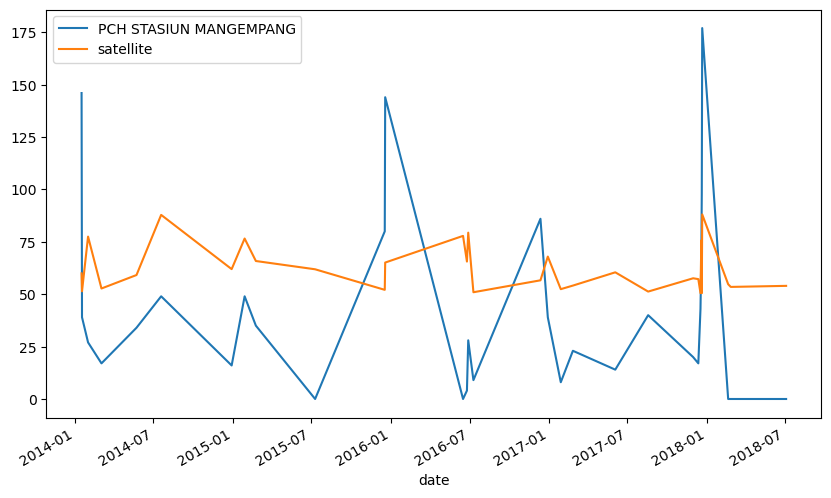

In [45]:
# setelah dikoreksi
st6.plot(x="date", y=[sta_name[6],'satellite'],
        kind="line", figsize=(10, 6))

<Axes: xlabel='date'>

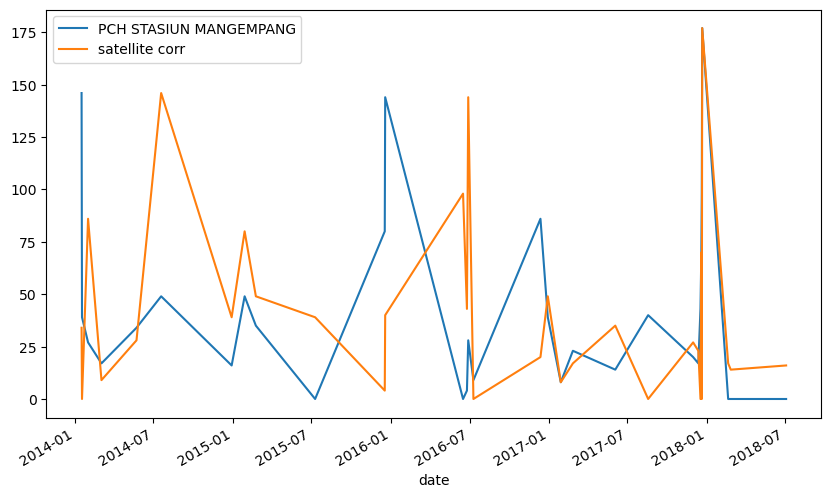

In [44]:
# setelah dikoreksi
st6.plot(x="date", y=[sta_name[6],'satellite corr'],
        kind="line", figsize=(10, 6))

__Kesimpulan__ :
- pakai `lebat1`, script `satellite` dulu baru `obs`
- pakai stasiun `PCH STASIUN MANGEMPANG`, indeks di sta_name `ke-1`

## CH Sangat Lebat

### Script dibalik, satellite dulu baru obs

In [47]:
tabel_performa=pd.DataFrame(columns=['stasiun','rmse','rmse corr','rmse wo otl','rmse wo otl corr',\
                                     'korelasi','korelasi corr','korelasi wo otl','korelasi wo otl corr'])
path='D:/Happy/satellite_correction/klasifikasi_hujan/classified_CHIRPS/acuan_koreksi/'
value='Sangat_Lebat'
sta=pd.ExcelFile(path+'Hasil_CHIRPSStasiunJeneberang_classified_'+value+'.xlsx')
sta_name=sta.sheet_names

for i in range (len(sta_name)):
    globals()['st'+str(i)]=pd.read_excel(path+'Hasil_CHIRPSStasiunJeneberang_classified_'+value+'.xlsx',\
              sheet_name=sta_name[i])
    globals()['st'+str(i)]=globals()['st'+str(i)].dropna()
    obs_st=globals()['st'+str(i)].iloc[:,3]
    satellite_st=globals()['st'+str(i)].iloc[:,1]

    r1,p1=stats.pearsonr(obs_st, satellite_st)
    rmse1=mean_squared_error(obs_st, satellite_st)

    #quantileMapping Bias Correction
    satellite_corr=QuantileMappinBR(satellite_st,obs_st)
    r2,p2=stats.pearsonr(obs_st, satellite_corr)
    rmse2=mean_squared_error(obs_st, satellite_corr)
    globals()['st'+str(i)]['satellite corr']=satellite_corr

    #without outlier
    sss=globals()['st'+str(i)]
    globals()['st'+str(i)+'wo_otl']=sss[(sss.iloc[:,3]<250) & (sss.iloc[:,1]<250)]

    obs_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,3]
    satellite_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,1]
    r3,p3=stats.pearsonr(obs_st_wo_otl, satellite_st_wo_otl)
    rmse3=mean_squared_error(obs_st_wo_otl, satellite_st_wo_otl)

    #quantileMapping Bias Correction without outlier
    satellite_corr_wo_otl=QuantileMappinBR(satellite_st_wo_otl, obs_st_wo_otl)
    r4,p4=stats.pearsonr(obs_st_wo_otl, satellite_corr_wo_otl)
    rmse4=mean_squared_error(obs_st_wo_otl, satellite_corr_wo_otl)
    globals()['st'+str(i)+'wo_otl']['satellite corr wo otl']=satellite_corr_wo_otl


    tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
                    'rmse':rmse1,'rmse corr':rmse2,'rmse wo otl':rmse3,'rmse wo otl corr':rmse4,\
                    'korelasi':r1,'korelasi corr':r2,\
                    'korelasi wo otl':r3,'korelasi wo otl corr':r4}]))

tabel_performa=tabel_performa.reset_index()
tabel_performa=tabel_performa.iloc[:,1:]
tabel_performa.sort_values(by=['korelasi corr','rmse corr'], inplace=True,
               ascending = [False, True])

# get index of best corrector
sangat_lebat1=tabel_performa.stasiun[0]

tabel_performa

C:\Users\MSIX\AppData\Local\Temp\ipykernel_9748\940267044.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
C:\Users\MSIX\AppData\Local\Temp\ipykernel_9748\940267044.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
C:\Users\MSIX\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\MSIX\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\MSIX\anac

,stasiun,rmse,rmse corr,rmse wo otl,rmse wo otl corr,korelasi,korelasi corr,korelasi wo otl,korelasi wo otl corr
0,PCH STASIUN LIMBUNGA,9054.267621,7164.304862,9054.267621,7164.304862,-0.801485,1.000000,-0.801485,1.000000
1,PCH STASIUN MANGEMPANG,11816.655573,11280.823305,11816.655573,11280.823305,-0.600103,1.000000,-0.600103,1.000000
5,PCH STASIUN MALINO,13294.680012,11719.939822,13294.680012,11719.939822,-0.883639,1.000000,-0.883639,1.000000
8,PCH STASIUN BILI-BILI,5131.516218,4844.078190,5131.516218,4844.078190,-0.288141,0.967763,-0.288141,0.967763
4,PCH STASIUN KD1,7109.162189,6513.462478,7109.162189,6513.462478,-0.754544,0.914568,-0.754544,0.914568
3,PCH STASIUN KAMPILI,10871.627668,10744.016523,10871.627668,10744.016523,0.463808,0.858297,0.463808,0.858297
6,PCH STASIUN PANAIKANG,14051.168537,10112.527929,14051.168537,10112.527929,NaN,NaN,NaN,NaN
2,PCH STASIUN LENGKESE,24153.457717,12918.658868,24153.457717,12918.658868,NaN,NaN,NaN,NaN
7,PCH STASIUN POS1,32923.255322,19135.759313,22701.804733,19135.759313,NaN,NaN,NaN,NaN


### Script Quantile_Mapping(obs,satellite)

In [51]:
tabel_performa=pd.DataFrame(columns=['stasiun','rmse','rmse corr','rmse wo otl','rmse wo otl corr',\
                                     'korelasi','korelasi corr','korelasi wo otl','korelasi wo otl corr'])
path='D:/Happy/satellite_correction/klasifikasi_hujan/classified_CHIRPS/acuan_koreksi/'
value='Sangat_Lebat'
sta=pd.ExcelFile(path+'Hasil_CHIRPSStasiunJeneberang_classified_'+value+'.xlsx')
sta_name
for i in range (len(sta_name)):
    globals()['st'+str(i)]=pd.read_excel(path+'Hasil_CHIRPSStasiunJeneberang_classified_'+value+'.xlsx',\
              sheet_name=sta_name[i])
    globals()['st'+str(i)]=globals()['st'+str(i)].dropna()
    #print ('st'+str(i))
    obs_st=globals()['st'+str(i)].iloc[:,3]
    satellite_st=globals()['st'+str(i)].iloc[:,1]
    r1,p1=stats.pearsonr(obs_st, satellite_st)
    rmse1=mean_squared_error(obs_st, satellite_st)

    #quantileMapping Bias Correction
    satellite_corr=QuantileMappinBR(obs_st,satellite_st)
    r2,p2=stats.pearsonr(obs_st, satellite_corr)
    rmse2=mean_squared_error(obs_st, satellite_corr)
    globals()['st'+str(i)]['satellite corr']=satellite_corr

    #without outlier
    sss=globals()['st'+str(i)]
    globals()['st'+str(i)+'wo_otl']=sss[(sss.iloc[:,3]<250) & (sss.iloc[:,1]<250)]

    obs_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,3]
    satellite_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,1]
    r3,p3=stats.pearsonr(obs_st_wo_otl, satellite_st_wo_otl)
    rmse3=mean_squared_error(obs_st_wo_otl, satellite_st_wo_otl)

    #quantileMapping Bias Correction without outlier
    satellite_corr_wo_otl=QuantileMappinBR(obs_st_wo_otl, satellite_st_wo_otl)
    r4,p4=stats.pearsonr(obs_st_wo_otl, satellite_corr_wo_otl)
    rmse4=mean_squared_error(obs_st_wo_otl, satellite_corr_wo_otl)


    tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
                    'rmse':rmse1,'rmse corr':rmse2,'rmse wo otl':rmse3,'rmse wo otl corr':rmse4,\
                    'korelasi':r1,'korelasi corr':r2,\
                    'korelasi wo otl':r3,'korelasi wo otl corr':r4}]))

tabel_performa=tabel_performa.reset_index()
tabel_performa=tabel_performa.iloc[:,1:]
tabel_performa.sort_values(by=['korelasi corr','rmse corr'], inplace=True,
               ascending = [False, True])
# get index of best corrector
sangat_lebat2=tabel_performa.stasiun[0]

tabel_performa

C:\Users\MSIX\AppData\Local\Temp\ipykernel_9748\3564857538.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
C:\Users\MSIX\AppData\Local\Temp\ipykernel_9748\3564857538.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
C:\Users\MSIX\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\MSIX\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\MSIX\an

,stasiun,rmse,rmse corr,rmse wo otl,rmse wo otl corr,korelasi,korelasi corr,korelasi wo otl,korelasi wo otl corr
3,PCH STASIUN KAMPILI,10871.627668,32.666667,10871.627668,32.666667,0.463808,0.852705,0.463808,0.852705
8,PCH STASIUN BILI-BILI,5131.516218,669.666667,5131.516218,669.666667,-0.288141,-0.144512,-0.288141,-0.144512
5,PCH STASIUN MALINO,13294.680012,96.000000,13294.680012,96.000000,-0.883639,-0.500000,-0.883639,-0.500000
1,PCH STASIUN MANGEMPANG,11816.655573,4160.666667,11816.655573,4160.666667,-0.600103,-0.500000,-0.600103,-0.500000
0,PCH STASIUN LIMBUNGA,9054.267621,6144.000000,9054.267621,6144.000000,-0.801485,-0.500000,-0.801485,-0.500000
4,PCH STASIUN KD1,7109.162189,3821.000000,7109.162189,3821.000000,-0.754544,-0.948993,-0.754544,-0.948993
2,PCH STASIUN LENGKESE,24153.457717,0.000000,24153.457717,0.000000,NaN,NaN,NaN,NaN
6,PCH STASIUN PANAIKANG,14051.168537,0.000000,14051.168537,0.000000,NaN,NaN,NaN,NaN
7,PCH STASIUN POS1,32923.255322,0.000000,22701.804733,0.000000,NaN,NaN,NaN,NaN


<Axes: xlabel='date'>

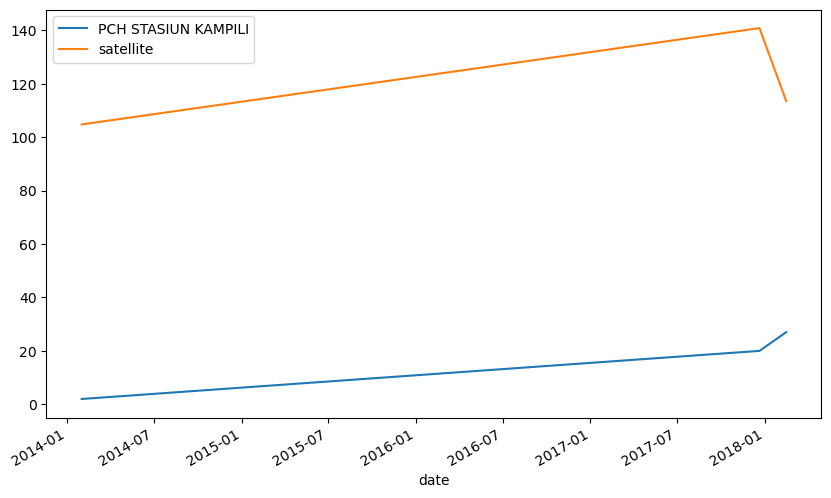

In [53]:
# setelah dikoreksi
st3.plot(x="date", y=[sta_name[3],'satellite'],
        kind="line", figsize=(10, 6))

<Axes: xlabel='date'>

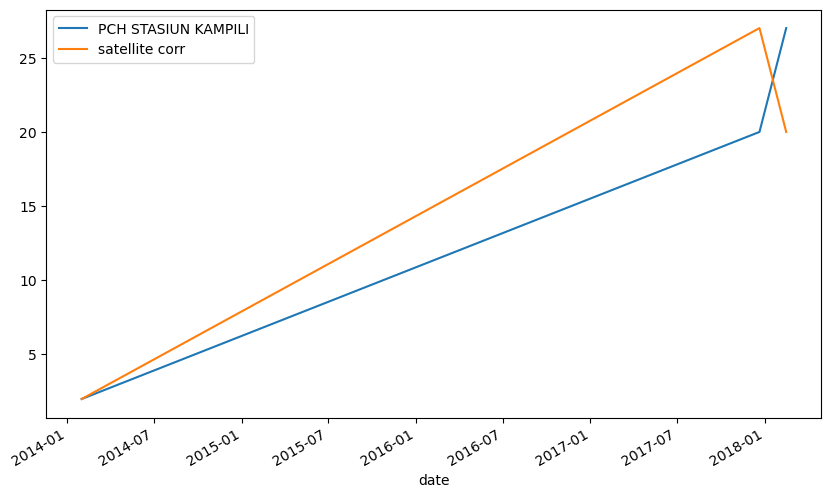

In [52]:
# setelah dikoreksi
st3.plot(x="date", y=[sta_name[3],'satellite corr'],
        kind="line", figsize=(10, 6))

__Kesimpulan__ :
- pakai `sangat_lebat2`, script `obs` dulu baru `satellite`
- pakai stasiun `PCH STASIUN KAMPILI`, indeks di sta_name `ke-3`

## Faktor Koreksi

In [27]:
from bias_correction import BiasCorrection, XBiasCorrection

### Ringan

In [28]:
# get the name of the gage from file name
path=r'D:\Happy\satellite_correction\data_satellite\Bilibili_Rainfall\classified_Bilibili_Rainfall\box_shape_data'
ringan_tb_corr = glob.glob(path + "/*_Ringan*.xlsx") # for many files, use this script
ringan_tb_corr

['D:\\Happy\\satellite_correction\\data_satellite\\Bilibili_Rainfall\\classified_Bilibili_Rainfall\\box_shape_data\\Bilibili_sat_box_classified_Ringan.xlsx']

In [29]:
# check the name of the model by checking the name of excel file
ringan_tb_corr[-1][107:-31]

'Bilibili'

In [30]:
## RINGAN
path_acuan=r'D:\Happy\satellite_correction\klasifikasi_hujan\classified_CHIRPS\acuan_koreksi'
xls = pd.ExcelFile(ringan_tb_corr[0])
indeks_sta_acuan=sta_name.index(ringan1)
# Now you can list all sheets in the file

gages=xls.sheet_names
print (gages)
model_satellite=ringan_tb_corr[0][107:-31]
print (model_satellite)

for gage in gages: #loop for each gage in model
    print (gage)
    globals()[model_satellite+"_ringan_"+gage]=pd.read_excel(ringan_tb_corr[0],sheet_name=gage)
    globals()[model_satellite+"_ringan_"+gage]=globals()[model_satellite+"_ringan_"+gage].iloc[:,1:]

    #ini harus di-loop untuk tiap stasiun obs ter-qc (untuk reference bias correction data yg harus dikoreksi)
    globals()['st'+str(indeks_sta_acuan)]=pd.read_excel(path_acuan+'/Hasil_CHIRPSStasiunJeneberang_classified_Ringan.xlsx',sheet_name=ringan1)
    obs_st=globals()['st'+str(indeks_sta_acuan)].iloc[:,3]
    satellite_st=globals()['st'+str(indeks_sta_acuan)].iloc[:,1]

    bc = BiasCorrection(satellite_st,obs_st,globals()[model_satellite+"_ringan_"+gage].loc[:,'gage'])
    corrected = bc.correct(method='basic_quantile')
    #simpan corrected ke dalam tambahan tabel
    globals()[model_satellite+"_ringan_"+gage]["satellite terkoreksi"]=corrected
    globals()[model_satellite+"_ringan_"+gage]['date'] = \
    pd.to_datetime(globals()[model_satellite+"_ringan_"+gage]['date'])

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103']
Bilibili
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103


### Sedang

In [31]:
# get the name of the gage from file name
path=r'D:\Happy\satellite_correction\data_satellite\Bilibili_Rainfall\classified_Bilibili_Rainfall\box_shape_data'
sedang_tb_corr = glob.glob(path + "/*_Sedang*.xlsx") # for many files, use this script
sedang_tb_corr

['D:\\Happy\\satellite_correction\\data_satellite\\Bilibili_Rainfall\\classified_Bilibili_Rainfall\\box_shape_data\\Bilibili_sat_box_classified_Sedang.xlsx']

In [32]:
sedang_tb_corr[-1][107:-31]

'Bilibili'

In [33]:
## SEDANG
path_acuan=r'D:\Happy\satellite_correction\klasifikasi_hujan\classified_CHIRPS\acuan_koreksi'
xls = pd.ExcelFile(sedang_tb_corr[0])
indeks_sta_acuan=sta_name.index(sedang1)
# Now you can list all sheets in the file

gages=xls.sheet_names
print (gages)
model_satellite=sedang_tb_corr[0][107:-31]
print (model_satellite)

for gage in gages: #loop for each gage in model
    print (gage)
    globals()[model_satellite+"_sedang_"+gage]=pd.read_excel(sedang_tb_corr[0],sheet_name=gage)
    globals()[model_satellite+"_sedang_"+gage]=globals()[model_satellite+"_sedang_"+gage].iloc[:,1:]

    #ini harus di-loop untuk tiap stasiun obs ter-qc (untuk reference bias correction data yg harus dikoreksi)
    globals()['st'+str(indeks_sta_acuan)]=pd.read_excel(path_acuan+'/Hasil_CHIRPSStasiunJeneberang_classified_Sedang.xlsx',sheet_name=sedang1)
    obs_st=globals()['st'+str(indeks_sta_acuan)].iloc[:,3]
    satellite_st=globals()['st'+str(indeks_sta_acuan)].iloc[:,1]

    bc = BiasCorrection(satellite_st,obs_st,globals()[model_satellite+"_sedang_"+gage].loc[:,'gage'])
    corrected = bc.correct(method='basic_quantile')
    #simpan corrected ke dalam tambahan tabel
    globals()[model_satellite+"_sedang_"+gage]["satellite terkoreksi"]=corrected
    globals()[model_satellite+"_sedang_"+gage]['date'] = \
    pd.to_datetime(globals()[model_satellite+"_sedang_"+gage]['date'])

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103']
Bilibili
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103


### Lebat

In [34]:
# get the name of the gage from file name
path=r'D:\Happy\satellite_correction\data_satellite\Bilibili_Rainfall\classified_Bilibili_Rainfall\box_shape_data'
lebat_tb_corr = glob.glob(path + "/*_Lebat.xlsx")[:1] # for many files, use this script
lebat_tb_corr

['D:\\Happy\\satellite_correction\\data_satellite\\Bilibili_Rainfall\\classified_Bilibili_Rainfall\\box_shape_data\\Bilibili_sat_box_classified_Lebat.xlsx']

In [35]:
lebat_tb_corr[0][107:-30]

'Bilibili'

In [36]:
## LEBAT
path_acuan=r'D:\Happy\satellite_correction\klasifikasi_hujan\classified_CHIRPS\acuan_koreksi'
xls = pd.ExcelFile(lebat_tb_corr[0])
indeks_sta_acuan=sta_name.index(lebat1)
# Now you can list all sheets in the file

gages=xls.sheet_names
print (gages)
model_satellite=lebat_tb_corr[0][107:-30]
print (model_satellite)

for gage in gages: #loop for each gage in model
    print (gage)
    globals()[model_satellite+"_lebat_"+gage]=pd.read_excel(lebat_tb_corr[0],sheet_name=gage)
    globals()[model_satellite+"_lebat_"+gage]=globals()[model_satellite+"_lebat_"+gage].iloc[:,1:]

    #ini harus di-loop untuk tiap stasiun obs ter-qc (untuk reference bias correction data yg harus dikoreksi)
    globals()['st'+str(indeks_sta_acuan)]=pd.read_excel(path_acuan+'/Hasil_CHIRPSStasiunJeneberang_classified_Lebat.xlsx',sheet_name=lebat1)
    obs_st=globals()['st'+str(indeks_sta_acuan)].iloc[:,3]
    satellite_st=globals()['st'+str(indeks_sta_acuan)].iloc[:,1]

    bc = BiasCorrection(satellite_st,obs_st,globals()[model_satellite+"_lebat_"+gage].loc[:,'gage'])
    corrected = bc.correct(method='basic_quantile')
    #simpan corrected ke dalam tambahan tabel
    globals()[model_satellite+"_lebat_"+gage]["satellite terkoreksi"]=corrected
    globals()[model_satellite+"_lebat_"+gage]['date'] = \
    pd.to_datetime(globals()[model_satellite+"_lebat_"+gage]['date'])

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103']
Bilibili
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103


In [37]:
globals()[model_satellite+"_lebat_"+gage]

,date,gage,Klasifikasi,satellite terkoreksi
0,1981-05-26,78.167564,Lebat,94.147910
1,1981-07-06,65.674225,Lebat,81.654570
2,1981-07-07,65.674225,Lebat,81.654570
3,1982-02-06,61.163956,Lebat,77.144301
4,1982-06-09,83.592064,Lebat,99.572409
...,...,...,...,...
281,2022-09-04,50.830929,Lebat,83.703351
282,2022-09-06,50.747726,Lebat,83.620149
283,2022-09-22,56.190083,Lebat,72.170428
284,2022-11-07,59.636730,Lebat,75.617076


### Sangat Lebat

In [38]:
# get the name of the gage from file name
path=r'D:\Happy\satellite_correction\data_satellite\Bilibili_Rainfall\classified_Bilibili_Rainfall\box_shape_data'
sangat_lebat_tb_corr = glob.glob(path + "/*_Sangat_lebat*.xlsx") # for many files, use this script
sangat_lebat_tb_corr

['D:\\Happy\\satellite_correction\\data_satellite\\Bilibili_Rainfall\\classified_Bilibili_Rainfall\\box_shape_data\\Bilibili_sat_box_classified_Sangat_Lebat.xlsx']

In [39]:
sangat_lebat_tb_corr[0][107:-37]

'Bilibili'

In [40]:
## SANGAT LEBAT
path_acuan=r'D:\Happy\satellite_correction\klasifikasi_hujan\classified_CHIRPS\acuan_koreksi'
xls = pd.ExcelFile(sangat_lebat_tb_corr[0])
indeks_sta_acuan=sta_name.index(sangat_lebat2)
# Now you can list all sheets in the file

gages=xls.sheet_names
print (gages)
model_satellite=sangat_lebat_tb_corr[0][107:-37]
print (model_satellite)

for gage in gages: #loop for each gage in model
    print (gage)
    globals()[model_satellite+"_sangat_lebat_"+gage]=pd.read_excel(sangat_lebat_tb_corr[0],sheet_name=gage)
    globals()[model_satellite+"_sangat_lebat_"+gage]=globals()[model_satellite+"_sangat_lebat_"+gage].iloc[:,1:]

    #ini harus di-loop untuk tiap stasiun obs ter-qc (untuk reference bias correction data yg harus dikoreksi)
    globals()['st'+str(indeks_sta_acuan)]=pd.read_excel(path_acuan+'/Hasil_CHIRPSStasiunJeneberang_classified_Sangat_Lebat.xlsx',sheet_name=sangat_lebat2)
    obs_st=globals()['st'+str(indeks_sta_acuan)].iloc[:,3]
    satellite_st=globals()['st'+str(indeks_sta_acuan)].iloc[:,1]

    bc = BiasCorrection(obs_st,satellite_st,globals()[model_satellite+"_sangat_lebat_"+gage].loc[:,'gage'])
    corrected = bc.correct(method='basic_quantile')
    #simpan corrected ke dalam tambahan tabel
    globals()[model_satellite+"_sangat_lebat_"+gage]["satellite terkoreksi"]=corrected
    globals()[model_satellite+"_sangat_lebat_"+gage]['date'] = \
    pd.to_datetime(globals()[model_satellite+"_sangat_lebat_"+gage]['date'])

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103']
Bilibili
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103


In [41]:
globals()[model_satellite+"_sangat_lebat_"+gage].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  37 non-null     datetime64[ns]
 1   gage                  37 non-null     float64       
 2   Klasifikasi           37 non-null     object        
 3   satellite terkoreksi  37 non-null     float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.3+ KB


In [42]:
globals()[model_satellite+"_sangat_lebat_"+gage]

,date,gage,Klasifikasi,satellite terkoreksi
0,1983-06-07,109.614868,Sangat_Lebat,2.213061
1,1988-09-02,110.030785,Sangat_Lebat,2.628977
2,1989-09-22,113.951302,Sangat_Lebat,31.711093
3,1990-05-17,112.216866,Sangat_Lebat,29.976657
4,1995-05-08,203.774918,Sangat_Lebat,177.299072
5,1995-05-12,146.125977,Sangat_Lebat,119.650131
6,1995-05-13,170.480301,Sangat_Lebat,144.004456
7,1995-06-06,106.741753,Sangat_Lebat,-0.660055
8,1995-06-16,239.450317,Sangat_Lebat,212.974472
9,1998-06-20,110.157135,Sangat_Lebat,27.916926


In [43]:
print (model_satellite+"_sangat_lebat_"+gage)

Bilibili_sangat_lebat_103


## Outer Join All Satellite Data per value for each gage

In [44]:
for model_excel in ringan_tb_corr:
    #ini harus di-loop untuk menyimpan data excel gpm per model untuk dikoreksi
    xls = pd.ExcelFile(model_excel)
    # Now you can list all sheets in the file
    gages=xls.sheet_names
    print (gages)
    model_satellite=model_excel[107:-31]
    print (model_satellite)

    for gage in gages: #loop for each gage in model
        globals()[model_satellite+gage] = pd.concat([globals()[model_satellite+"_sangat_lebat_"+gage], globals()[model_satellite+"_lebat_"+gage]])
        globals()[model_satellite+gage] = pd.concat([globals()[model_satellite+gage], globals()[model_satellite+"_sedang_"+gage]])
        globals()[model_satellite+gage] = pd.concat([globals()[model_satellite+gage], globals()[model_satellite+"_ringan_"+gage]])
        globals()[model_satellite+gage]=globals()[model_satellite+gage].sort_values(by='date')
        globals()[model_satellite+gage][globals()[model_satellite+gage]['satellite terkoreksi']<0] = 0
        globals()[model_satellite+gage].reset_index(drop=True, inplace=True)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103']
Bilibili


In [45]:
globals()[model_satellite+str(0)]['satellite terkoreksi'].values

array([16.1423866 , 38.12076283, 13.51759797, ...,  8.92094015,
        8.92094015,  8.92094015])

## Create NetCDF4 file from rainfall satellite and coordinates

In [46]:
path_out=r'D:\Happy\satellite_correction\data_satellite\netcdf_corrected'

In [47]:
coor=pd.read_excel('D:/Happy/satellite_correction/data_satellite/sat_index/Kotak2_CHIRPS_JeneberangIndeks.xlsx').iloc[:,1:]
coor

,longitude,latitude,lon_index,lat_index,Stasiun
0,119.375000,-5.475002,507,110,0
1,119.424988,-5.475002,508,110,1
2,119.475006,-5.475002,509,110,2
3,119.524994,-5.475002,510,110,3
4,119.575012,-5.475002,511,110,4
...,...,...,...,...,...
99,119.774994,-5.125000,515,117,99
100,119.825012,-5.125000,516,117,100
101,119.875000,-5.125000,517,117,101
102,119.924988,-5.125000,518,117,102


Now, we need to create information contains of the longitude and latitude (without meshgrid) for each grid name.

In [48]:
lat_sat=np.empty(coor.lat_index.nunique())
long_sat=np.empty(coor.lon_index.nunique())
rain_sat=np.empty((len(globals()[model_satellite+str(gage)]), coor.lat_index.nunique(),coor.lon_index.nunique()))

# initiation of gage name, latitude index, and longitude index
gage=coor.Stasiun[0]

for i in range (len(coor)):
    lat_i=coor.lat_index[i]-coor.lat_index.min()
    lon_i=coor.lon_index[i]-coor.lon_index.min()
    
    lat_sat[lat_i]=coor.latitude[i]
    long_sat[lon_i]=coor.longitude[i]

    gage=coor.Stasiun[i]
    print ('lon_i :'+ str(lon_i), '|| lat_i :'+str(lat_i))
    rain_sat[:,lat_i,lon_i]=globals()[model_satellite+str(gage)]['satellite terkoreksi'].values




lon_i :0 || lat_i :0
lon_i :1 || lat_i :0
lon_i :2 || lat_i :0
lon_i :3 || lat_i :0
lon_i :4 || lat_i :0
lon_i :5 || lat_i :0
lon_i :6 || lat_i :0
lon_i :7 || lat_i :0
lon_i :8 || lat_i :0
lon_i :9 || lat_i :0
lon_i :10 || lat_i :0
lon_i :11 || lat_i :0
lon_i :12 || lat_i :0
lon_i :0 || lat_i :1
lon_i :1 || lat_i :1
lon_i :2 || lat_i :1
lon_i :3 || lat_i :1
lon_i :4 || lat_i :1
lon_i :5 || lat_i :1
lon_i :6 || lat_i :1
lon_i :7 || lat_i :1
lon_i :8 || lat_i :1
lon_i :9 || lat_i :1
lon_i :10 || lat_i :1
lon_i :11 || lat_i :1
lon_i :12 || lat_i :1
lon_i :0 || lat_i :2
lon_i :1 || lat_i :2
lon_i :2 || lat_i :2
lon_i :3 || lat_i :2
lon_i :4 || lat_i :2
lon_i :5 || lat_i :2
lon_i :6 || lat_i :2
lon_i :7 || lat_i :2
lon_i :8 || lat_i :2
lon_i :9 || lat_i :2
lon_i :10 || lat_i :2
lon_i :11 || lat_i :2
lon_i :12 || lat_i :2
lon_i :0 || lat_i :3
lon_i :1 || lat_i :3
lon_i :2 || lat_i :3
lon_i :3 || lat_i :3
lon_i :4 || lat_i :3
lon_i :5 || lat_i :3
lon_i :6 || lat_i :3
lon_i :7 || lat_i :3
lon_

In [49]:
globals()[model_satellite+str(0)].date

0        1981-01-01 00:00:00
1        1981-01-02 00:00:00
2        1981-01-03 00:00:00
3        1981-01-04 00:00:00
4        1981-01-05 00:00:00
                ...         
15486    2023-05-27 00:00:00
15487    2023-05-28 00:00:00
15488    2023-05-29 00:00:00
15489    2023-05-30 00:00:00
15490    2023-05-31 00:00:00
Name: date, Length: 15491, dtype: object

In [50]:
time_sat_tmp=pd.date_range("1981-01-01", periods=len(globals()[model_satellite+str(0)]), freq="D")
time_sat=nc4.date2num(time_sat_tmp.to_pydatetime(), 'minutes since 1981-01-01 00:00:00')

In [51]:
time_sat_tmp.to_pydatetime()

array([datetime.datetime(1981, 1, 1, 0, 0),
       datetime.datetime(1981, 1, 2, 0, 0),
       datetime.datetime(1981, 1, 3, 0, 0), ...,
       datetime.datetime(2023, 5, 29, 0, 0),
       datetime.datetime(2023, 5, 30, 0, 0),
       datetime.datetime(2023, 5, 31, 0, 0)], dtype=object)

In [52]:
[dt.datetime(2014,10,1,0),dt.datetime(2014,10,2,0),dt.datetime(2014,10,3,0),dt.datetime(2014,10,4,0)]

[datetime.datetime(2014, 10, 1, 0, 0),
 datetime.datetime(2014, 10, 2, 0, 0),
 datetime.datetime(2014, 10, 3, 0, 0),
 datetime.datetime(2014, 10, 4, 0, 0)]

In [54]:
f= nc4.Dataset(path_out+'/CHIRPS_box_corrected_1981_2023.nc', 'w', format='NETCDF4')
tempgrp = f.createGroup('Rain_data')
f.createDimension('lon', len(long_sat))
f.createDimension('lat', len(lat_sat))
f.createDimension('Time', len(time_sat))

<class 'netCDF4._netCDF4.Dimension'>: name = 'Time', size = 15491

In [55]:
longitude = f.createVariable('longitude', 'f4', 'lon')
latitude = f.createVariable('latitude', 'f4', 'lat')
rain = f.createVariable('rain', 'f4', ('Time', 'lat', 'lon'))
time = f.createVariable('time', 'i4', 'Time')

In [56]:
longitude[:]=long_sat[:]
latitude[:]=lat_sat[:]
rain[:]=rain_sat[:]
time[:]=time_sat

In [57]:
# Add global attributes
f.description = 'CHIRPS corrected dataset - Bili-Bili'
f.history = "Created "+ dt.date.today().strftime("%d%m%y")

# Add local attributes
longitude.units = 'degree_east'
latitude.units = 'degree_north'
time.units = 'minutes since 1981-01-01 00:00:00'
rain.units = 'mm'

In [64]:
time_coba=f.variables['time'][:]
dates_coba=nc4.num2date(time_coba, f.variables['time'].units)
dates_coba

masked_array(data=[cftime.DatetimeGregorian(1981, 1, 1, 0, 0, 0, 0, has_year_zero=False),
                   cftime.DatetimeGregorian(1981, 1, 2, 0, 0, 0, 0, has_year_zero=False),
                   cftime.DatetimeGregorian(1981, 1, 3, 0, 0, 0, 0, has_year_zero=False),
                   ...,
                   cftime.DatetimeGregorian(2023, 5, 29, 0, 0, 0, 0, has_year_zero=False),
                   cftime.DatetimeGregorian(2023, 5, 30, 0, 0, 0, 0, has_year_zero=False),
                   cftime.DatetimeGregorian(2023, 5, 31, 0, 0, 0, 0, has_year_zero=False)],
             mask=False,
       fill_value='?',
            dtype=object)

In [65]:
f.close()

In [66]:
read_nc=nc4.Dataset(path_out+'/CHIRPS_box_corrected_1981_2023.nc', 'r')
read_nc['rain'][:]

masked_array(
  data=[[[16.142387 , 16.208502 , 16.351938 , ..., 15.776456 ,
          15.723481 , 14.931762 ],
         [15.812619 , 15.782762 , 15.725291 , ..., 15.940615 ,
          15.514948 , 15.282543 ],
         [16.100624 , 16.139948 , 16.286144 , ..., 15.717412 ,
          15.61116  , 14.618061 ],
         ...,
         [17.056204 , 17.005297 , 16.581371 , ..., 14.295647 ,
          14.000577 , 13.295882 ],
         [17.069162 , 17.24151  , 17.176256 , ..., 14.116819 ,
          13.524648 , 13.679713 ],
         [17.167799 , 17.638643 , 17.325283 , ..., 13.771131 ,
          13.574593 , 13.60602  ]],

        [[38.12076  , 38.245007 , 38.51455  , ..., 16.936733 ,
          16.438538 , 15.850556 ],
         [38.407555 , 38.351448 , 39.067204 , ..., 17.139126 ,
          16.614313 , 15.894895 ],
         [38.94877  , 39.02267  , 39.28972  , ..., 16.385376 ,
          16.254375 , 15.209343 ],
         ...,
         [17.91311  , 17.84408  , 18.101816 , ..., 16.747143 ,
          1

In [67]:
import matplotlib.pyplot as plt

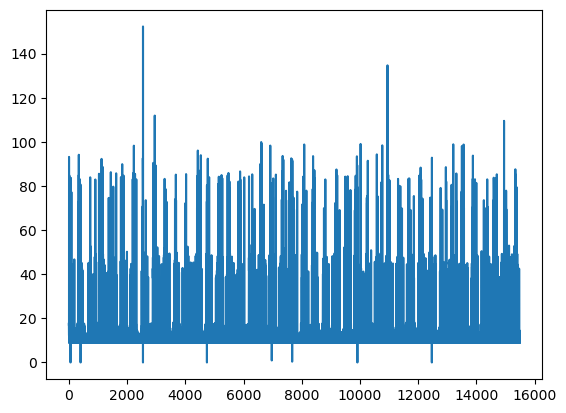

In [68]:
rain_coba=read_nc.variables['rain'][:]
plt.plot(rain[:,3,5])

In [69]:
lat_coba=read_nc.variables['latitude'][:]
lon_coba=read_nc.variables['longitude'][:]
xx,yy=np.meshgrid(lon_coba,lat_coba)

In [70]:
time_coba=read_nc.variables['time'][:]
dates_coba=nc4.num2date(time_coba, read_nc.variables['time'].units)

In [71]:
dates_coba

masked_array(data=[cftime.DatetimeGregorian(1981, 1, 1, 0, 0, 0, 0, has_year_zero=False),
                   cftime.DatetimeGregorian(1981, 1, 2, 0, 0, 0, 0, has_year_zero=False),
                   cftime.DatetimeGregorian(1981, 1, 3, 0, 0, 0, 0, has_year_zero=False),
                   ...,
                   cftime.DatetimeGregorian(2023, 5, 29, 0, 0, 0, 0, has_year_zero=False),
                   cftime.DatetimeGregorian(2023, 5, 30, 0, 0, 0, 0, has_year_zero=False),
                   cftime.DatetimeGregorian(2023, 5, 31, 0, 0, 0, 0, has_year_zero=False)],
             mask=False,
       fill_value='?',
            dtype=object)

In [72]:
from mpl_toolkits.basemap import Basemap

In [73]:
mBili = Basemap(llcrnrlon=xx.min()-1, llcrnrlat=yy.min()-1, urcrnrlon=xx.max()+1, urcrnrlat=yy.max()+1, resolution='i')

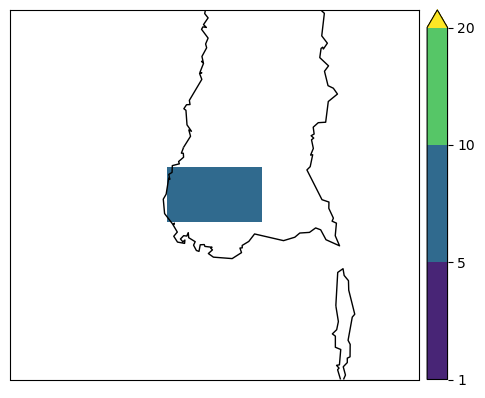

In [74]:
fig = plt.figure()
mBili.drawcoastlines(linewidth=1.0)

cs = mBili.contourf(xx,yy,rain_coba[1000,:,:], latlon=True,levels=[1,5,10,20],extend='max')

#mBili.drawparallels(np.linspace(-14,10, 5),labels=[1, 0, 0, 0],linewidth=0.5, dashes=[4, 4],fontsize=13, rotation=90) #lat
#mBili.drawparallels(np.linspace(-14,10, 5),labels=[0, 1, 0, 0],linewidth=0.5, dashes=[4, 4],fontsize=13, rotation=270) #lat
#mBili.drawmeridians(np.linspace(104,146, 5),labels=[0, 0, 1, 1],linewidth=0.5, dashes=[4, 4],fontsize=13) #lon


cb =mBili.colorbar(cs, ticks=[1,5,10,20],location='right')


plt.show()